# Homework 2
## Student: Davide Gariglio (s292964)
***

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

## Exercise 1

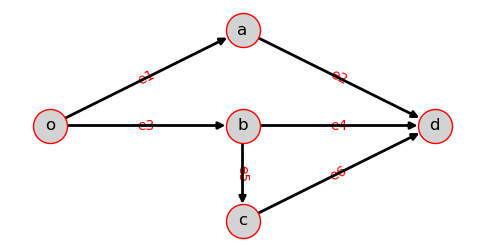

In [2]:
# graph creation 
G = nx.DiGraph()
G.add_edges_from([("o","a"), ("o","b"), ("a","d"), ("b","d"), ("b","c"), ("c","d")])

# draw Graph
fig, ax = plt.subplots(figsize=(6,3))

pos = {"o":[-1,0], "a":[0,1], "b":[0,0], "c":[0,-1], "d":[1,0]}
labels = {("o","a"): "e1", ("o","b"): "e3", ("a","d"): "e2", ("b","d"): "e4", ("b","c"): "e5", ("c","d"): "e6"}

nx.draw_networkx_edge_labels(G,  pos, edge_labels = labels, font_size = 10, font_color='red', ax = ax)

nx.draw(G, pos, node_size = 600, font_size=12, node_color='lightgray', with_labels=True, width=2, edge_color = 'black', edgecolors='red', ax=ax)


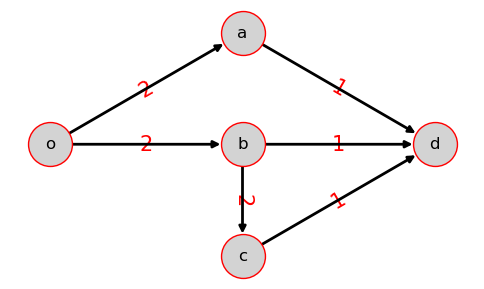

In [3]:
# capacities
G["o"]["a"]['capacity'] = 2
G["o"]["b"]['capacity'] = 2
G["a"]["d"]['capacity'] = 1
G["b"]["c"]['capacity'] = 2
G["b"]["d"]['capacity'] = 1
G["c"]["d"]['capacity'] = 1

#draw Graph
fig, ax = plt.subplots(figsize=(6,3.5))

nx.draw_networkx_edge_labels(G,pos,edge_labels={("o","a"): '2', ("o","b"): '2', ("a","d"): '1', ("b","d"):'1', ("b","c"):'2', ("c","d"):'1'}, font_size = 15, font_color='red', ax = ax)
nx.draw(G, pos, node_size = 1000, font_size=12, node_color='lightgray', with_labels=True, width=2, edge_color = 'black', edgecolors='red', ax=ax)
plt.savefig("imgs/graph1.png", format="png")

### 1.a) 
#### Min aggregate capacity that needs to be removed for no feasible flow from o to d to exist

# CONTROLLARE SE È mincut o mincut+1

In [4]:
# we should apply the max flow - min cut theorem
# by doing so we identify the min cut of g
source = 'o'
destination = 'd'
min_cut, partitions = nx.algorithms.flow.minimum_cut(G, source, destination)
print(f'The minimum cut capacity is: {min_cut}')
print(f'This cut creates the following partitions: {partitions}')

# we can check that the sum of the capacities flowing from the first (left partition
# to the second (right) partition is equal to three 
print('Thus, the minimum aggregate capacity that needs to be removed in order to have a non feasible',
      f'flow from {source} to {destination} is {min_cut}')

The minimum cut capacity is: 3
This cut creates the following partitions: ({'o', 'a', 'b', 'c'}, {'d'})
Thus, the minimum aggregate capacity that needs to be removed in order to have a non feasible flow from o to d is 3


### 1.b) 
#### Max aggregated capacity theat can be removed from links without affecting the max throughput from o to d

In [5]:
# we have to keep the thoughput constant while reducing the capacities of (some) links
# first, lets calculate max_flow

# we initialized the total capacity to be removed
removed_cap = 0

source = 'o'
destination = 'd'
flow_value, flow_dict = nx.algorithms.flow.maximum_flow(G, source, destination)
# we expect the flow value to be equal to the min cut flow found in the previous exercise ( = 3)
print(flow_value, flow_dict)
# we will need a new graph based on the original one in which we modify the capacities
# and remove the values that are not needed (original cap - residual cap not used)
new_G = nx.DiGraph(G)

for k in flow_dict.keys(): #for every node
    for neigh in flow_dict[k]: # for every neighbor of k (link = (k, neigh))
        # we remove the actual flow passing in the single link from the total capacity
        # obtaining a new graph with residual flows
        
        # extra cap will be always >= 0 
        # if we have an edge with all the capacity exploited, the extra cap will be = 0
        extra_cap = new_G[k][neigh]['capacity'] - flow_dict[k][neigh]
        
        # in case we have extra cap > 0, we update the total cap that can be removed
        if extra_cap > 0:
            
            new_G[k][neigh]['capacity'] -= extra_cap
            # print the involved link
            print(f'in link ({k},{neigh}) it is removed a capacity equal to: {extra_cap}')
            # update the total counter  
            removed_cap += extra_cap
            
print(f'The total capacity removed from the links without affecting the max throughput from {source} to {destination} is equal to: {removed_cap}')        

3 {'o': {'a': 1, 'b': 2}, 'a': {'d': 1}, 'b': {'d': 1, 'c': 1}, 'd': {}, 'c': {'d': 1}}
in link (o,a) it is removed a capacity equal to: 1
in link (b,c) it is removed a capacity equal to: 1
The total capacity removed from the links without affecting the max throughput from o to d is equal to: 2


### 1.c) 
#### given x>0 extra unit of capacity, how can we distribute it in order to minimize the throughput that can be sent from o to d? Add a plot for the max_throughput from o to d as a function of x

##### given the graph as it is, we have a max throughput equal to 3. It is given by the sum of the edges (a, d), (b, d) and (c, d) (coherently with min cut).
##### if we distribute a quantity x > 0, in order to increase the thoughput from o to d we have to increase the capacity of those nodes (which are the currect bottleneck of the network). Moreover, once we increased these values we have to keep in mind that the bottleneck would change; in particoular this will eventually include the other nodes (not anymore the ones entering in d).

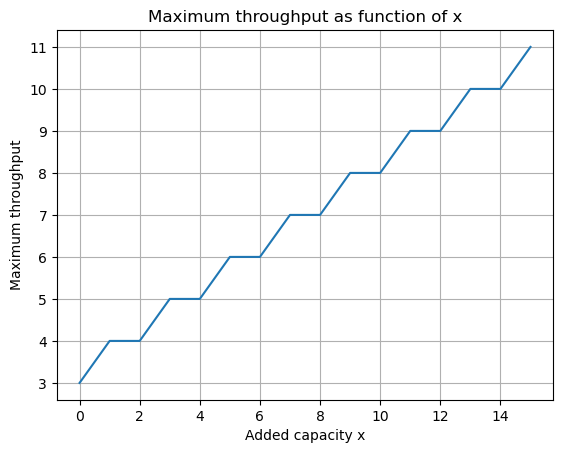

In [6]:
def extra_capacity_allocation(G, x, source, destination):
    # new graph containing the updated capacities
    new_G = nx.DiGraph(G)
    
    # keep track of throughput and x units in order to plot
    max_throughput = []
    x_values = []
    
    for i in range(0, x+1):
        # keep track of current x to plot
        x_values.append(i)
        # find bottleneck ---> calcualte mincut
        min_cut_value, min_cut = nx.algorithms.flow.minimum_cut(new_G, source, destination) 
        U_left = min_cut[0]
        U_right = min_cut[1]
        
        # keep track of edges involved in the min cut 
        edges = []
        
        #we iterate over the nodes of the partitions, check if there exists a link and save it
        for node_l in U_left:
            for node_r in U_right:
                if G.has_edge(node_l, node_r):
                    edges.append((node_l, node_r))
        # if extra capacity x > 0
        if i != 0:
            # we increase the capacity of an edge beloniging to the cut
            new_G[edges[0][0]][edges[0][1]]['capacity'] += 1
        # the graph has changed and we compute the max flow algorithm to plot the throughput
        flow_value, flow_dict = nx.algorithms.flow.maximum_flow(new_G, source, destination)

        #keep track of max flow (throughput) for the plot
        max_throughput.append(flow_value)
        
    plt.plot(x_values, max_throughput)
    plt.title('Maximum throughput as function of x')
    plt.xlabel('Added capacity x')
    plt.ylabel('Maximum throughput')
    plt.grid()
    plt.savefig('imgs/1c.png', format='png')
    plt.show()
# we define an arbitrary x
x = 15
source = 'o'
destination = 'd'
extra_capacity_allocation(G, x, source, destination)        


##### for every odd value of x extra capacity added in the network, we can increase the maximum throughput

## Exercise 2

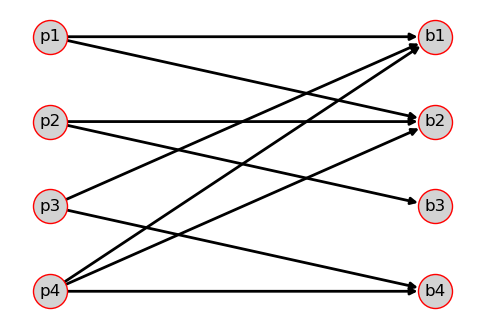

In [7]:
#G bipartite graph if undirected. We use the directed one
G = nx.DiGraph()
G.add_edges_from([("p1","b1"), ("p1","b2"), ("p2","b2"), ("p2","b3"), ("p3","b1"), ("p3","b4"), ("p4","b1"), ("p4","b2"), ("p4","b4")])

#Draw the Bipartite Graph
fig, ax = plt.subplots(figsize=(6,4))

pos = {"p1":[0,2], "p2":[0,1], "p3":[0,0], "p4":[0,-1], "b1":[1,2], "b2":[1,1], "b3":[1,0], "b4":[1,-1]}
nx.draw(G, pos, node_size = 600, font_size=12, node_color='lightgray', with_labels=True, width=2, edge_color = 'black', edgecolors='red', ax=ax)

plt.savefig("imgs/plot2.1.png", format="png")

### 2.a) 
#### Explot max-flow problem in order to find a perfect matching, if any is present.

##### We have a bipartite graph
##### We can add a source and a target nodes; the first one is connected with the first partition (every persons pi) and the last one with the second partition (every books bj)

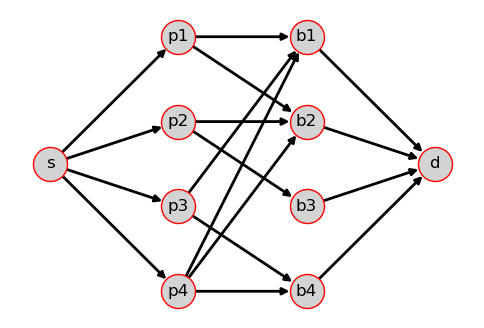

In [8]:
# we add source and targed nodes to th eoriginal graph
G.add_edges_from([("s","p1"), ("s","p2"), ("s","p3"), ("s","p4"), ("b1","d"), ("b2", "d"), ("b3","d"), ("b4","d")])

# we also define a unitary capacity for every arc
# unitary capacity
G["p1"]["b1"]['capacity']=1
G["p1"]["b2"]['capacity']=1
G["p2"]["b2"]['capacity']=1
G["p2"]["b3"]['capacity']=1
G["p3"]["b1"]['capacity']=1
G["p3"]["b4"]['capacity']=1
G["p4"]["b1"]['capacity']=1
G["p4"]["b2"]['capacity']=1
G["p4"]["b4"]['capacity']=1
G["s"]["p1"]['capacity']=1
G["s"]["p2"]['capacity']=1
G["s"]["p3"]['capacity']=1
G["s"]["p4"]['capacity']=1
G["b1"]["d"]['capacity']=1
G["b2"]["d"]['capacity']=1
G["b3"]["d"]['capacity']=1
G["b4"]["d"]['capacity']=1

# draw graph
fig, ax = plt.subplots(figsize=(6,4))

pos = {"p1":[0,2], "p2":[0,1], "p3":[0,0], "p4":[0,-1], "b1":[1,2], "b2":[1,1], "b3":[1,0], "b4":[1,-1], "s":[-1,0.5], "d":[2,0.5]}
nx.draw(G, pos, node_size = 600, font_size=12, node_color='lightgray', with_labels=True, width=2, edge_color = 'black', edgecolors='red', ax=ax)

plt.savefig("imgs/graph2_directed.png", format="png")

Max flow:  4
Flow dict {'p1': {'b1': 0, 'b2': 1}, 'b1': {'d': 1}, 'b2': {'d': 1}, 'p2': {'b2': 0, 'b3': 1}, 'b3': {'d': 1}, 'p3': {'b1': 1, 'b4': 0}, 'b4': {'d': 1}, 'p4': {'b1': 0, 'b2': 0, 'b4': 1}, 's': {'p1': 1, 'p2': 1, 'p3': 1, 'p4': 1}, 'd': {}}


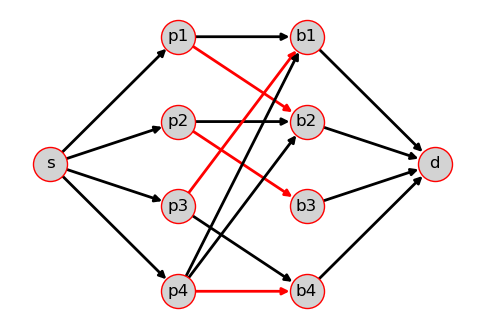

In [9]:
# now we apply max flow
# only arcs with used capacity equal to one belongs to the perfect matching
flow_value, flow_dict = nx.algorithms.flow.maximum_flow(G, "s", "d")
print("Max flow: ", flow_value)
print("Flow dict", flow_dict)

# we now create a mask in order to represent in red the edges involved in the matching
edge_color = [] # this will be the mask used to change the color of the links
for k, v in flow_dict.items():
    for node, link in v.items():
        if node == 'd' or k =='s':
            edge_color.append('black')
        else:
            if link == 0:
                edge_color.append('black')
            else:
                edge_color.append('red')
# print(edge_color)
fig, ax = plt.subplots(figsize=(6,4))

pos = {"p1":[0,2], "p2":[0,1], "p3":[0,0], "p4":[0,-1], "b1":[1,2], "b2":[1,1], "b3":[1,0], "b4":[1,-1], "s":[-1,0.5], "d":[2,0.5]}
nx.draw(G, pos, node_size = 600, font_size=12, node_color='lightgray', with_labels=True, width=2, edge_color = edge_color, edgecolors='red', ax=ax)
plt.savefig("imgs/graph2_match.png", format="png")

#check with mincut
#min_cut, partitions = nx.algorithms.flow.minimum_cut(G, 's', 'd')
#print(min_cut, partitions)

### 2.b) 
#### Now assume that there are multiple copies of the books available, in particular consider the following vector of book copies: (2; 3; 2; 2).
#### Exploit the analogy with max-flow problem to establish how many books of interest can be assigned in total.


Max flow:  8
Flow dict {'p1': {'b1': 0, 'b2': 1}, 'b1': {'d': 2}, 'b2': {'d': 3}, 'p2': {'b2': 1, 'b3': 1}, 'b3': {'d': 1}, 'p3': {'b1': 1, 'b4': 1}, 'b4': {'d': 2}, 'p4': {'b1': 1, 'b2': 1, 'b4': 1}, 's': {'p1': 1, 'p2': 2, 'p3': 2, 'p4': 3}, 'd': {}}


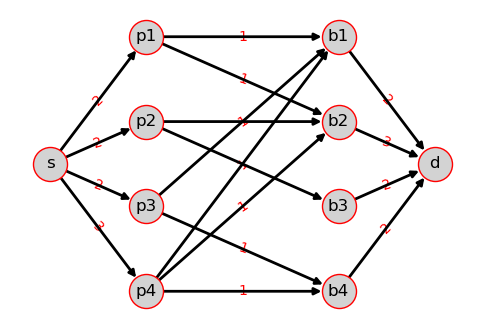

In [10]:
# now we have to change the capacity of the arcs

# new capacities
G["s"]["p1"]['capacity']=2
G["s"]["p2"]['capacity']=2
G["s"]["p3"]['capacity']=2
G["s"]["p4"]['capacity']=3
G["b1"]["d"]['capacity']=2
G["b2"]["d"]['capacity']=3
G["b3"]["d"]['capacity']=2
G["b4"]["d"]['capacity']=2

# Max-flow of Graph
flow_value, flow_dict = nx.algorithms.flow.maximum_flow(G, "s", "d")
print("Max flow: ", flow_value)
print("Flow dict", flow_dict)

# draw Graph
fig, ax = plt.subplots(figsize=(6,4))

edge_colors = ["black","black","black","black","black","black","black","black","black","black","black","black","black","black","black","black","black"]

pos = {"p1":[0,2], "p2":[0,1], "p3":[0,0], "p4":[0,-1], "b1":[2,2], "b2":[2,1], "b3":[2,0], "b4":[2,-1], "s":[-1,0.5], "d":[3,0.5]}
labels = nx.get_edge_attributes(G, 'capacity')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels, font_size=10, font_color='red')
nx.draw(G, pos, node_size = 600, font_size=12, node_color='lightgray', with_labels=True, width=2, edge_color = edge_colors, edgecolors='red', ax=ax)

#plt.savefig("imgs/plot2.3.png", format="png")

#check with mincut
# min_cut, partitions = nx.algorithms.flow.minimum_cut(G, 's', 'd')
# print(min_cut, partitions)

### 2.c) 
#### Suppose that the library can sell a copy of a book and buy a copy of another book. Which books should be sold and bought to maximize the number of assigned books?
##### We can add and remove a unit in the book vector (we aim to obtain all balanced nodes. So the sum of in-node weights = to the sum of out-node weights. DEMAND = OFFER)

In [11]:
# We analyze node by node (excluding source node)

nodes = G.nodes
edges = G.edges

for node in nodes:
    
    inflow = 0
    outflow = 0
    max_possible_out_flow = 0
    
    # source node is not needed
    if node == 's':
        continue
        
    # inflow in sink is the max possible flow (basically, the number of books)
    if node == 'd':
        # calculate max possible flow
        for u, v, data in G.in_edges(node, data = True):
            max_possible_out_flow = sum(data.values()) + max_possible_out_flow
    
    # inflow of a general node (person or book)
    for u, v, data in G.in_edges(node, data = True):
        inflow = sum(data.values()) + inflow

    # outflow of a general node (person or book)
    for u, v, data in G.out_edges(node, data = True):
        outflow = sum(data.values()) + outflow
    
    # netflow = inflow - outflow of the node
    netflow = inflow - outflow

    # if a node, excluding source and target, has netflow != 0, than we can 
    # modify the capacity vector in order to balance
    if netflow != 0 and node != "s" and node != "d":
        print(f"Node {node} not optimized, netflow is {netflow}")

print("Max possible outflow: ", max_possible_out_flow)

Node b1 not optimized, netflow is 1
Node b3 not optimized, netflow is -1
Max possible outflow:  9


## Exercise 3

In [12]:
import scipy.io 
import scipy
import cvxpy as cp
%matplotlib inline

np.set_printoptions(precision=2, suppress= True)

#### Read input matrices

In [13]:
flow_mat = scipy.io.loadmat('matrices/flow.mat')["flow"].reshape(28,)
capacity_mat = scipy.io.loadmat('matrices/capacities.mat')["capacities"].reshape(28,)
traffic_mat = scipy.io.loadmat('matrices/traffic.mat')["traffic"]
trav_time_mat = scipy.io.loadmat('matrices/traveltime.mat')["traveltime"].reshape(28,)

#### Graph creation

In [14]:
G = nx.DiGraph()

# the given graph has 17 nodes and 28 edges (so 28 capacities)
n_edges = len(capacity_mat) # 28
n_nodes = len(traffic_mat)  # 17
for c in range(n_edges):
    
    # we store the weights (capacity and travel time)
    cap = capacity_mat[c]
    trav_time = trav_time_mat[c]
    
    # we check for every other node if there exists a link
    # -1 means that the link is entering in the other node
    # +1 means that the link is going out from the other node
    
    for r in range(n_nodes):
        if traffic_mat[r][c]==1:
            i=r
        if traffic_mat[r][c]==-1:
            j=r
    
    # after the found head and tail of the edge, we add it to the graph
    G.add_edges_from([(i+1, j+1)], capacity = cap, traveltime = trav_time)

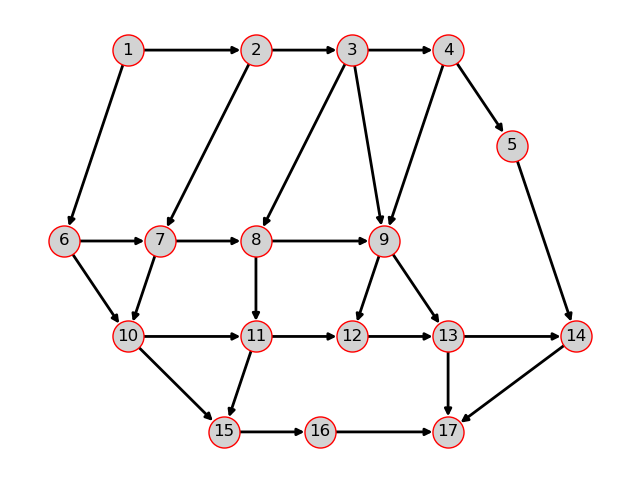

In [15]:
fig, ax = plt.subplots(figsize=(8,6))

pos = {1:[-3,1], 2:[-1,1], 3:[0.5,1], 4:[2,1], 5:[3,0], 6:[-4,-1], 7:[-2.5,-1], 8:[-1,-1], 9:[1,-1], 
       10:[-3,-2], 11:[-1,-2], 12:[0.5,-2], 13:[2,-2], 14:[4,-2], 15:[-1.5,-3], 16:[0,-3], 17:[2,-3]}

nx.draw(G, pos, node_size = 500, font_size=12, node_color='lightgray', with_labels=True, width=2, edge_color = 'black', edgecolors='red', ax=ax)

plt.savefig("imgs/graph3.png", format='png')

### 3.a) 
#### Find the shortest path between node 1 and 17 (with shortest travelling time considering and empty network)

In [16]:
source_node = 1
target_node = 17
shortest_path = nx.shortest_path(G, source = source_node, target = target_node, weight = 'traveltime')
shortest_path_length = nx.shortest_path_length(G, source = source_node, target = target_node, weight='traveltime')
print(f'The shortest path from {source_node} to {target_node} is: {shortest_path}')
print(f'This shortest path is characterized by a length of: {shortest_path_length} h ({shortest_path_length*60} min)')

The shortest path from 1 to 17 is: [1, 2, 3, 9, 13, 17]
This shortest path is characterized by a length of: 0.532996 h (31.979760000000002 min)


Graph showing the shortest path from 1 to 17 ([1, 2, 3, 9, 13, 17])


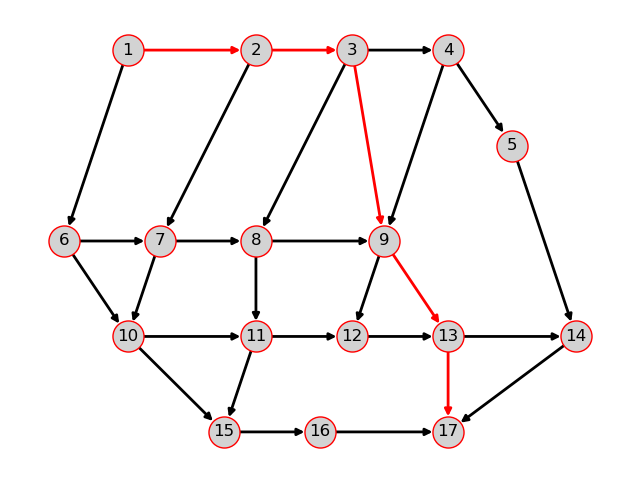

In [17]:
# print shortest path
# given the shortest path, we create a mask
#in order to print the graph with the edges belonging to the shortest path in red

fig, ax = plt.subplots(figsize=(8,6))

edge_colors = ["red","black","red","black","black","black","red","black","black","black",
               "black","black","black","black","black","black","red","black","black","red",
               "black","black","black","black","black","black","black", "black"]
nx.draw(G, pos, node_size = 500, font_size=12, node_color='lightgray', with_labels=True, width=2, edge_color = edge_colors, edgecolors='red', ax=ax)

plt.savefig("imgs/graph3_shortest_path.png", format='png')

print(f'Graph showing the shortest path from {source_node} to {target_node} ({shortest_path})')


### 3.b) 
#### Max-flow from node 1 to node 17

In [18]:
# In order to find the maximum flow between node 1 and 17 we can directly use the max_flow algorithm present in nx
# As we have seen in the theory, this value must be equal to the minimum_cut capacity

max_flow_value, max_flow_dict = nx.algorithms.flow.maximum_flow(G,source_node,target_node)
print("Maximum flow from node 1 to 17: ", max_flow_value)
print("Minimum cut :", nx.algorithms.flow.minimum_cut(G,source_node,target_node)[0])
# Max flow and Min cut values are equal

print("Max flow dictionary:", max_flow_dict)

Maximum flow from node 1 to 17:  22448
Minimum cut : 22448
Max flow dictionary: {1: {2: 8741, 6: 13707}, 2: {3: 8741, 7: 0}, 3: {4: 0, 8: 0, 9: 8741}, 4: {5: 0, 9: 0}, 5: {14: 0}, 6: {7: 4624, 10: 9083}, 7: {8: 4624, 10: 0}, 8: {9: 4624, 11: 0}, 9: {13: 6297, 12: 7068}, 13: {14: 3835, 17: 10355}, 14: {17: 3835}, 10: {11: 825, 15: 8258}, 11: {12: 825, 15: 0}, 15: {16: 8258}, 12: {13: 7893}, 17: {}, 16: {17: 8258}}


### 3.c) 
#### compute the external inflow $v$ satisfying $Bf = v$, taking as input the flow vector presenti in flow.mat


In [19]:
# v : external inflow
B = traffic_mat
f = flow_mat
v = B @ f
v

array([ 16806,   8570,  19448,   4957,   -746,   4768,    413,     -2,
        -5671,   1169,     -5,  -7131,   -380,  -7412,  -7810,  -3430,
       -23544], dtype=int32)

### 3.d) 
#### Find the social optimum $f^*$ taking the delays on different links $T _{e}(f _{e})$; in order to to this, minimize the cost function $ \sum_{e \in \varepsilon}^{} \left ( \frac{f _{e}l _{e} }{ 1 - f _{e}/C _{e} } - l _{e}C _{e}  \right ) $

In [20]:
# As suggested in the homework specifications, we are going to use cvxpy library to solve the linear problem

# We have to minimize the given obj function taking into account the usal constrints
# mass conservation
# non negative flow
# flows <= capacities

# we set in and out (node 1 and 17) exogenous net flow vector values equal and all the others zero
nu = np.array([v[0],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, -v[0]]) 
# we need a variable for every edge. the f vector will contain all the flows, so all the variables
f = cp.Variable(n_edges)

# Cost function definition
func = cp.multiply(trav_time_mat*capacity_mat, cp.inv_pos(1 - cp.multiply(f,1/capacity_mat))) - trav_time_mat*capacity_mat                                   
func = cp.sum(func)

# minimization of the cost function
objective = cp.Minimize(func)

# definition of the constraints
constraints = [B @ f == nu, f >=0, f <= capacity_mat]

# definition of the problem
problem = cp.Problem(objective, constraints)

# solution of the probelm
cost_opt = problem.solve()

opt_flow = f.value
print("Social optimal flow:", opt_flow)
print("Optimal cost:", cost_opt)

Social optimal flow: [ 6642.2   6058.94  3132.33  3132.33 10163.8   4638.32  3006.34  2542.63
  3131.54   583.26     0.01  2926.6      0.    3132.33  5525.48  2854.27
  4886.45  2215.24   463.72  2337.69  3317.99  5655.68  2373.11     0.
  6414.12  5505.43  4886.45  4886.45]
Optimal cost: 25943.62261121288


### 3.e) 
#### Find the Wardrop equilibrium $f^{ (0)}$. For this use cost function: $ \sum_{e \in \varepsilon}^{} \int_{0}^{f _{e}} T _{e}(s)ds $

In [21]:
# In order to solve the Wardrop equilibrium flow, we have have to solve the same linear
# problem as before, but with a different cost function

#cost function 

#merlo cost function integral solution
integral = - cp.multiply(trav_time_mat * capacity_mat, cp.log( 1 - (cp.multiply(f, 1/capacity_mat) )))

func = cp.sum(integral)


#minimize cost function
objective = cp.Minimize(func)

# define the constraints
constraints = [B @ f == nu, f >=0, f <= capacity_mat]

# create the problem
problem = cp.Problem(objective, constraints)

# solve the problem
cost_w = problem.solve()

print("Wardrop equilibrium flow:", f.value)

war_vect = f.value

Wardrop equilibrium flow: [ 6715.65  6715.65  2367.41  2367.41 10090.35  4645.39  2803.84  2283.56
  3418.48     0.     176.83  4171.41     0.    2367.41  5444.96  2353.17
  4933.34  1841.55   697.11  3036.49  3050.28  6086.77  2586.51     0.
  6918.74  4953.92  4933.34  4933.34]


In [22]:
def cost(f):
    tot = []
    for i, value in enumerate(f):
        tot.append(((trav_time_mat[i]*capacity_mat[i]) / (1-(value/capacity_mat[i])))-trav_time_mat[i]*capacity_mat[i])
    return sum(tot)

cost_w = cost(war_vect) 

print("Wardrop cost:", cost_w)

PoA = cost_w/cost_opt

print("The price of anarchy:", PoA)  

Wardrop cost: 26292.963874629393
The price of anarchy: 1.013465400289377


### 3.f) 
#### Now we introduce a toll for every link e equal to $\omega _{e} = f^* _{e}{T _{e}}'(f^* _{e})$, where $f^* _{e}$ is the flow at the system optimum. Now the delay on link e is given by  $T _{e} (f_e)+ \omega _{e} $. Compute the new Wardrop equilibrium $ f^{(w)} $.

In [23]:
# every driver now has a perceived cost equal to the delay + toll
# As requested, the toll is a function of the flow in the social optimum
f = cp.Variable(n_edges)

#compute omega
omega = []
for i, value in enumerate(opt_flow):
    omega.append(value*((capacity_mat[i]*trav_time_mat[i])/((capacity_mat[i]-value)**2)))

# is the same integral as before, but with omega integrated in f too.
func3 = cp.sum(cp.multiply(omega, f) - cp.multiply(capacity_mat*trav_time_mat, cp.log(1-(cp.multiply(f, 1/capacity_mat)))))

objective = cp.Minimize(func3)
constraints = [B @ f == nu, f >=0, f <= capacity_mat]
prob = cp.Problem(objective, constraints)

result = prob.solve()

print("Wardrop equilibrium with tolls:", f.value)

Wardrop equilibrium with tolls: [ 6642.97  6059.08  3132.47  3132.47 10163.03  4638.26  3006.33  2542.34
  3131.49   583.9      0.    2926.6      0.    3132.47  5524.77  2854.23
  4886.37  2215.83   463.99  2337.45  3318.22  5655.67  2373.04     0.
  6414.12  5505.51  4886.37  4886.37]


In [24]:
war_vect = f.value
#compute cost of wardrop equilibrium
cost_w = cost(war_vect) 

print("Wardrop cost:", cost_w)

PoA = cost_w/cost_opt

print("The price of anarchy:", PoA) 

Wardrop cost: 25943.62261534188
The price of anarchy: 1.000000000159153


### 3.g) 
#### Now modify the cost function and set it equal to the additional delay with respect to the delay in free flow (lenght of the road). In particular set $\psi _{e} = f _{e}( T _{e}(f _{e}) - l _{e} )$ subject to flow constraint. First, compute the system optimum $f^*$ for the costs given.

In [25]:
f = cp.Variable(n_edges)

#cost function free flow delay
func4 = cp.sum(cp.multiply( cp.multiply(trav_time_mat, capacity_mat), cp.inv_pos(1 - cp.multiply(f, 1/capacity_mat) ) ) - cp.multiply(trav_time_mat, capacity_mat) - cp.multiply(trav_time_mat,f) )

objective = cp.Minimize(func4)
constraints = [B @ f == nu, f >=0, f <= capacity_mat]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
cost_opt = prob.solve()

# The optimal value for f is stored in `f.value`.
opt_flow = f.value
print("Social optimal flow:", opt_flow)
print("Optimal cost:", cost_opt)

Social optimal flow: [ 6653.3   5774.66  3419.72  3419.71 10152.7   4642.78  3105.84  2662.18
  3009.08   878.63     0.01  2354.94     0.01  3419.71  5509.92  3043.69
  4881.81  2415.57   443.66  2008.05  3487.35  5495.4   2203.78     0.
  6300.7   5623.49  4881.81  4881.81]
Optimal cost: 15095.51352460787


#### Second, Construct tolls $\omega^* _{e}$ such that the new Wardrop equilibrium with the constructed tolls $f^{(\omega^*)}$ coincides with $f^{*}$ (so that the system optimum coincides with the Wardrop equilibrium)

In [26]:
w = cp.Variable(n_edges)
nu = np.array([16806, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -16806])

# cost function with optimal flow
integral = - cp.multiply(capacity_mat*trav_time_mat, cp.log(1-(cp.multiply(opt_flow, 1/capacity_mat)))) - cp.multiply(opt_flow,trav_time_mat) + cp.multiply(w, opt_flow)
func5 = cp.sum(integral)

objective = cp.Minimize(func5)
# omega becomes the new f
constraints = [B @ w == nu, w>=0]
prob = cp.Problem(objective, constraints)

result_w = prob.solve()

print("Constructed tolls:", w.value)

constr_tolls = w.value

Constructed tolls: [16806.     0.     0.     0.     0.     0. 16806.     0.     0. 16806.
     0.     0.     0.     0.     0.     0.     0.     0. 16806.     0.
     0.     0.     0. 16806.     0.     0. 16806. 16806.]


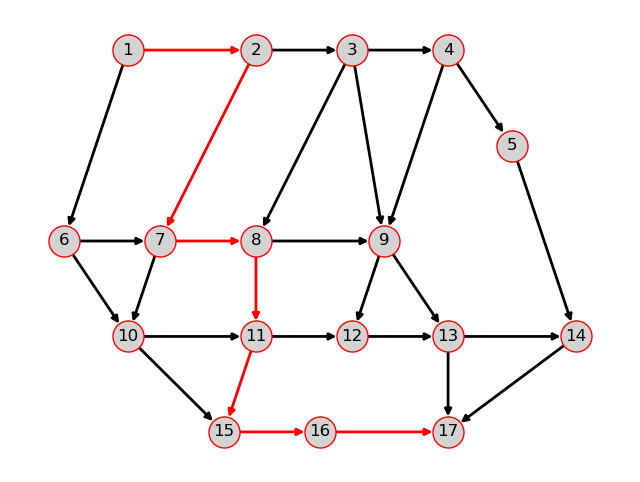

In [28]:
# Visualization of the tolls in the graph

fig, ax = plt.subplots(figsize=(8,6))

edge_colors = ["red","black","black","red","black","black","black","black","black","black",
               "black","black","red","black","black","red","black","black","black","black",
               "black","black","black","black","red","red","black", "red"]

nx.draw(G, pos, node_size = 500, font_size=12, node_color='lightgray', with_labels=True, width=2, edge_color = edge_colors, edgecolors='red', ax=ax)

plt.savefig("imgs/graph3_tolls.png", format='png')

In [29]:
# if everything is correct, we should get a POA(0) = 1
f = cp.Variable(n_edges)
nu = np.array([16806, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -16806])

func = - cp.multiply(capacity_mat*trav_time_mat, cp.log(1-(cp.multiply(f, 1/capacity_mat)))) - cp.multiply(f,trav_time_mat) + cp.multiply(constr_tolls, f)

objective = cp.Minimize(cp.sum(func))
constraints = [B @ f == nu, f >=0, f <= capacity_mat, f==opt_flow]
prob = cp.Problem(objective, constraints)

result_w = prob.solve()

print("Wardrop equilibrium:", f.value)

Wardrop equilibrium: [ 6653.3   5774.66  3419.72  3419.71 10152.7   4642.78  3105.84  2662.18
  3009.08   878.63     0.01  2354.94     0.01  3419.71  5509.92  3043.69
  4881.81  2415.57   443.66  2008.05  3487.35  5495.4   2203.78     0.
  6300.7   5623.49  4881.81  4881.81]


In [30]:
def cost2(f):
    tot = []
    for i, value in enumerate(f):
        tot.append(((trav_time_mat[i]*capacity_mat[i]) / (1-(value/capacity_mat[i])))-trav_time_mat[i]*capacity_mat[i]-trav_time_mat[i]*value)
    return sum(tot)

war_vect = f.value
cost_w = cost2(war_vect) 

print("Wardrop cost:", cost_w)

PoA = cost_w/cost_opt

print("The price of anarchy:", PoA) 

Wardrop cost: 15095.513347476217
The price of anarchy: 0.9999999882659406
